# Miniproject 2: Chatbot

## Introduction

### Description

Developing a model employing ANN on real-world data requires going through several major steps, each of which with 
important design choices that directly impact the final results. 
In this project, we guide you through these choices starting from a large database of 
[conversations](http://parl.ai/downloads/personachat/personachat.tgz) to a functional chatbot. 

### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/).
- You should know the concepts "recurrent neural networks", "LSTM", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will be guided through a data processing procedure and understand the importance of design choices in ANN modeling
- You will learn how to define recurrent neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed in the lecture, like "overfitting", "LSTM network", and "Generative model".
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night and make sure you save (and load) your data and models.

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. 
We will only do random tests of your code and not re-run the full notebook. 
Please ensure that your notebook is fully executed before handing it in. 

### Submission 

You should submit your notebook through the Moodle page submission tool. You should work in teams of two people and each member should submit the same notebook to Moodle.



## Functions and imports

For your convenience we import some libraries and provide some functions below. Fill in your names, sciper numbers and run the following cell.

In [1]:
names = {'student_1': "Keshav Singh",
        'student_2': "Ann-Onymous"}

sciper = {'student_1': 281922, 
          'student_2': 888888}

seed = sciper['student_1']+sciper['student_2']

%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os, sys
import copy
from keras.preprocessing.sequence import pad_sequences

plt.rcParams['font.size'] = 28
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False
c = plt.rcParams['axes.prop_cycle'].by_key()['color']

import keras
from keras.models import Model, load_model
from keras.layers import Input, Masking, TimeDistributed, Dense, Concatenate, Dropout, LSTM, GRU, SimpleRNN, Bidirectional, Embedding, BatchNormalization
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping
import seaborn as sns
#sns.set(style="whitegrid")

def getRawDataFromFile(datapath="data/personachat/", file="train_both_revised.txt"):
    
    f = open(datapath+file)

    conversations = []
    current_conversation = []
    
    for l, line in enumerate(f):
        #print(l, line)
        if "persona:" in line:
            if len(current_conversation) > 1:
                conversations.append(current_conversation)
            current_conversation = [] 
            continue

        #remove numberings
        processed_line = line.split(' ')
        processed_line = " ".join(processed_line[1:])
        line = processed_line
        #print(line)

        conv = line.split('\t')    
        q = conv[0]
        a = conv[1]
        current_conversation.append(q)
        current_conversation.append(a)
    
    return conversations 

Using TensorFlow backend.


## Data visualization and preprocessing

Here we will process and visualize the data.


### Parse raw data 

Download the dataset on http://parl.ai/downloads/personachat/personachat.tgz. Unpack it and add it to your project folder. Read and run the getRawDataFromFile function (if needed, modify the default path). It extracts the conversations.

**Output** Display two randomly selected conversations. [1 pt]

In [2]:
#train data
inputDataTrain = getRawDataFromFile(datapath="data2/personachat/")
inputDataTest = getRawDataFromFile(datapath="data2/personachat/", file="test_both_revised.txt")
inputDataValid = getRawDataFromFile(datapath="data2/personachat/", file='valid_both_revised.txt')

In [3]:
# 2 random conversations printed below
from random import randint
print(inputDataTrain[randint(0,len(inputDataTrain))])
print('The length of the raw training conversation is %d' % len(inputDataTrain))


['hello there . how are you today ?', 'i am good thank you for asking . sipping some tea now', 'how nice . just finished cycling class .', 'cool . what do you do in your free time ? i write , usually short stories .', 'that is awsome . read a lot apart from my general manger job at the grocery store', 'cool ! i used to work in a store that sold a lot of books', 'i love getting lost in the books . sometimes travel to canada to relax', 'that sounds fun ! i also enjoy art museums .', 'that is amazing . ny has a lot of museums here', 'i would love to visit one day !', 'yes . highly recommend it . i have been here once and decided to move here', 'i should move there maybe i could become a publisher .', 'my good friend is an editor at simon and schuster', 'wow i hope to become one some day .', 'you will ! as long as you work hard at it , you will get there !', 'thanks ! i keep working towards it for sure !']
The length of the raw training conversation is 8938


In [4]:
print(inputDataTest[randint(0,len(inputDataTest))])
print('The length of the raw testing conversation is %d' % len(inputDataTest))


['i have horses , i love them and work together with them', 'i just graduated school . i am gonna get married soon', 'my other hobbies are cooking by using it from my garden', 'when i was in hs i played basketball but now i rather watch it on tv', 'that is so nice , i love john denver by the way', 'i absolutely love soccer i wish i still played', 'i know what you mean , i grew up in a horse ranch that is so large .', 'i wish my childhood was as exciting', 'do you work out daily ? i do .', 'yes its a habit i played soccer in hs so i still stick to that regiment', 'i want to learn soccer we can work out together', 'cool i can show you the ropes', 'i can teach you to ride horses .', 'now that looks cool i would love to', 'we can cook from the foods in my garden', 'i love cooking with fresh vegetables']
The length of the raw testing conversation is 967


### Extract word tokens

Let's start looking at our data. 

**Code** Compute the set of unique words (dictionary) in all sentences along with the number of occurences of each of these words. HINT: each word is separated by a space character, use the python string.split(' ') function to separate words. Consider punctuations as 'words'. [1 pt]

**Figure** In a bar plot, show the first 75 most frequent words (x-axis) and their number of occurences (y-axis). [1 pt]

**Figure** In another bar plot, show the 75 least frequent words (x-axis) and their number of occurences (y-axis). [1 pt] 

**Figure** In a log-log scale, plot the sorted word index (x-axis) vs their respective count (y-axis). [1 pt]

**Question** Relate the sorted word count distribution with Zipf's law.
Argue using the log-log plot. [1 pt]

**Answer** : The simplest case of Zipf's law is a "1⁄f function." Given a set of Zipfian distributed frequencies, sorted from most common to least common, the second most common frequency will occur ½ as often as the first. The third most common frequency will occur ⅓ as often as the first. The fourth most common frequency will occur ¼ as often as the first. The nth most common frequency will occur 1⁄n as often as the first. In human languages, word frequencies have a very heavy-tailed distribution, and can therefore be modeled reasonably well by a Zipf distribution with an s close to 1. And heavy tailed distributions are straight lines in log log plot which we can see in the plot contained frequencies of word sorted in decreasing order of frequency.  

**Question** How many words appear only once in the entire dataset? [1 pt]

**Answer** : 7080 



In [5]:
# count all words in the input dataset 
from collections import Counter
def countWords ( inputData):
    counter = Counter()
    for input_ in inputData:
        for line in input_:
            for word in line.split(' '):
                counter[word] += 1
    return counter

training_counter = countWords(inputDataTrain)

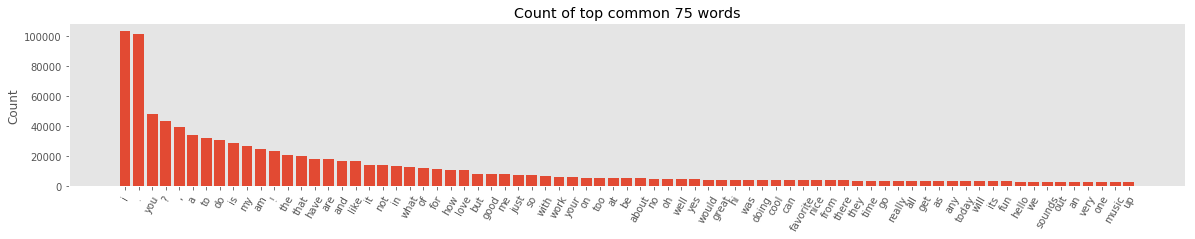

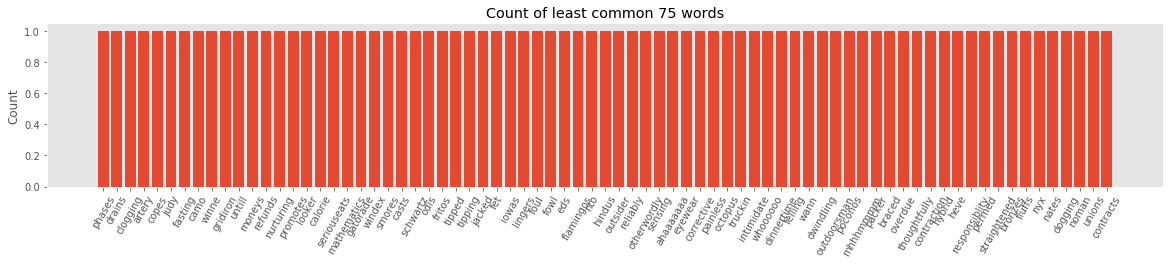

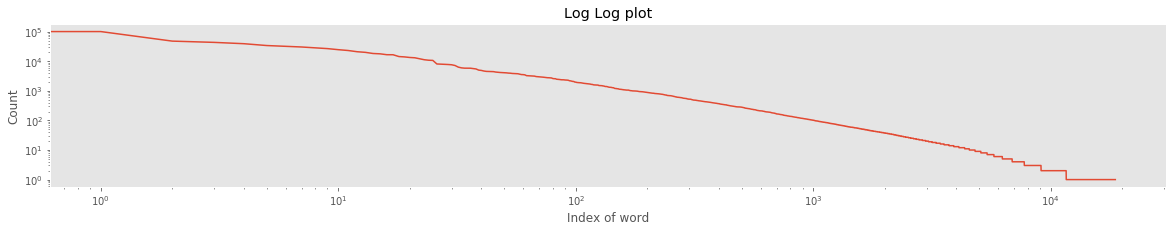

In [6]:
#plots here 

def makeBarPlot(list_tupes,title = "Count of top common 75 words",take_log=False):
    plt.rcParams["figure.figsize"] = (20,3)
    people =[tuple_[0] for tuple_ in list_tupes]
    score = [tuple_[1] for tuple_ in list_tupes]
    x_pos = np.arange(len(people))
    if(take_log):
        plt.loglog(x_pos,score)
        plt.xlabel('Index of word')
    else:
        plt.bar(x_pos, score,align='center')
    
        plt.xticks(x_pos, people) 
        plt.xticks(rotation=60)
    plt.ylabel('Count')
    plt.title(title)
    plt.show()
makeBarPlot(training_counter.most_common(75))
makeBarPlot(training_counter.most_common()[:-75-1:-1],title = "Count of least common 75 words")
makeBarPlot(training_counter.most_common(),title = "Log Log plot", take_log=True)

In [7]:
print("Count of words appearing simply once")
print(len([tuple_ for tuple_ in training_counter.most_common() if tuple_ [1] == 1]))

Count of words appearing simply once
7080


### Filtering

We suggest to filter your data by removing sentences containing rare words. 


**Code** To achieve that, you should create a new dataset where sentences containing rare words (words that occur less than N times in the dataset) are removed. Keep at least 50'000 sentences (depending on your computing power, you can keep more). 
HINT: Start by updating the dictionary accordingly and then remove any sentence that contains at least a single word that is not in the dictionary of words. [2 pts]

**Question**: How much did you reduce the number of unique words with your rare event suppression procedure? [1 pt]
    
**Answer**:  Originally there were 18673 words and after filtering, 1007 words remain 

**Question**: How many sentences are in your filtered and original dataset? [1 pt]

**Answer**: in original there's 131424, in filtered there's 50793

**Question**: What is the impact on learning and generalization of removing sentences with rare words from your dataset? [2 pt]

**Answer**: It will largely decrease the dimension and computation load, also avoids overfitting to the sentences with rare words.

In [8]:
def filter_less_than(inputData,counter,k=100):
    list_words = [tuple_[0] for tuple_ in counter.most_common() if tuple_ [1] <= k]
    set_words = set(list_words)
    newData = []
    num_original_sentences = 0
    num_new_sentences = 0
    for input_ in inputData:
        list_lines = []
        for line in input_:
            num_original_sentences += 1
            rareWordsInLine = [word for word in line.split(' ') if word in set_words]
            if(len(rareWordsInLine)==0):
                list_lines.append(line)
                num_new_sentences+= 1
        if(len(list_lines)>0):
            newData.append( list_lines)
    list_words_kept = [tuple_[0] for tuple_ in counter.most_common() if tuple_ [1] > k]
    words_to_index = {word:i+1 for (i,word) in enumerate(list_words_kept)}
    index_to_words = {i+1:word for (i,word) in enumerate(list_words_kept)}
    return num_original_sentences,num_new_sentences,newData,words_to_index,index_to_words




for i in [1,10,100,1000]:
    num_original,num_new , newData,words_to_index,_ = filter_less_than(inputDataTrain,training_counter,i)
    if(i==1):
        print("num of sentences in original is {}".format(num_original))
        print("num of words in original dataset is {}".format(len(training_counter)))
    print("num of sentences after filtering < {} count rare words is {}".format(i,num_new))
    print("num of words after filtering < {} count rare words is {}".format(i,len(words_to_index)))

#finally keep sentences with words having > 100 count words only
num_original,num_new , newData,word_to_index,index_to_word = filter_less_than(inputDataTrain,training_counter)
newData = [item for sublist in newData for item in sublist]
newData = [sentence.split(" ") for sentence in newData]
print("final num of sentences after filtering < {} count rare words is {}".format(100,num_new))
print("final num of words after filtering < {} count rare words is {}".format(100,len(word_to_index)))


num of sentences in original is 131424
num of words in original dataset is 18673
num of sentences after filtering < 1 count rare words is 124910
num of words after filtering < 1 count rare words is 11593
num of sentences after filtering < 10 count rare words is 102704
num of words after filtering < 10 count rare words is 4532
num of sentences after filtering < 100 count rare words is 50793
num of words after filtering < 100 count rare words is 1007
num of sentences after filtering < 1000 count rare words is 11068
num of words after filtering < 1000 count rare words is 174
final num of sentences after filtering < 100 count rare words is 50793
final num of words after filtering < 100 count rare words is 1007


### Tokenization and padding

Now you will transform our filtered data into a format that is understandable by an ANN. To achieve that, you should transform words to integers, where single integers in the range [1,size of the dictionary] are mapped to single words in your dictionary. This process is commonly named 'tokenization'. In addition, we will keep the value 0 to a specific artificial word 'PADD' that will be used to account for the variable length of sentences and add to each sentence a 'START' and an 'END' word. 

**Code** Start by adding the three artificial words to your dictionary (list of possible tokens) and then translate every sentences to a list of integers. 
HINT: use the Python List index() method. [2 pts]

**Figure** Use the violinplot to show the density of tokenized sentences length. [1pt]

**Code** From this figure, select a maximum number (=maxlen) of tokens for which most of the sentences have less. Padd (and eventually truncate) all sentences with the 'PADD' token (value 0 in the integer representation) until all tokenized sentences have the same length (maxlen).
HINT: use the pad_sequences function from keras.preprocessing.sequence [2 pts]

**Code** Check that you can recover the original sentence. Randomly select two sentences from your integer and padded representation and translate them back using your dictionary. [1 pt]

In [9]:
def data_replace_from_dict(sentences,word_to_index , sentence_len = -1, top_k=-1,replaced_type_= 'word',):
    list_sentences_indices = []
    
    if(top_k>0):
        sentences = sentences[:top_k]
    for sentence in sentences:
        list_words = []
        if(replaced_type_=='word'):
            if(sentence_len>0):
                sentence= sentence[:sentence_len]
            sentence = ["#START"] + sentence + ["#END"]
        for word in sentence: 
            if(replaced_type_=='word'):
                list_words.append(word_to_index[word]) # 1 is for pad
            else:
                list_words.append(word_to_index[word]) # -1 to invert +1 done earlier
        list_sentences_indices.append(list_words)
    return list_sentences_indices

#original sentences
print(newData[:10])
word_to_index['#PADD'] = 0
index_to_word[0]="#PADD"
word_to_index['#START'] = max(index_to_word)+1
index_to_word[max(index_to_word)+1] = '#START'
word_to_index["#END"] = max(index_to_word)+1
index_to_word[max(index_to_word)+1] = '#END'
print(word_to_index["#END"])
print(word_to_index["#START"])

new_data_index = data_replace_from_dict(newData,word_to_index)

#words after replacing with indices and then replacing back with 
print(new_data_index[:10])
print(data_replace_from_dict(new_data_index,index_to_word,top_k= 10,replaced_type_= 'int'))


[['you', 'must', 'be', 'very', 'fast', '.', 'hunting', 'is', 'one', 'of', 'my', 'favorite', 'hobbies', '.'], ['that', 'is', 'awesome', '.', 'do', 'you', 'have', 'a', 'favorite', 'season', 'or', 'time', 'of', 'year', '?'], ['what', 'is', 'your', 'favorite', 'meat', 'to', 'eat', '?'], ['hi', ',', 'how', 'are', 'you', 'doing', 'today', '?'], ['i', 'am', 'spending', 'time', 'with', 'my', '4', 'sisters', 'what', 'are', 'you', 'up', 'to'], ['wow', ',', 'four', 'sisters', '.', 'just', 'watching', 'game', 'of', 'thrones', '.'], ['i', 'agree', '.', 'what', 'do', 'you', 'do', 'for', 'a', 'living', '?'], ['that', 'is', 'cool', 'my', 'mom', 'does', 'the', 'same', 'thing'], ['tell', 'me', 'more', 'about', 'yourself'], ['i', 'enjoy', 'hanging', 'with', 'my', 'mother', 'she', 'is', 'my', 'best', 'friend']]
1009
1008
[[1008, 3, 200, 38, 72, 385, 2, 663, 9, 73, 23, 10, 51, 144, 2, 1009], [1008, 14, 9, 109, 2, 8, 3, 15, 6, 51, 610, 103, 56, 23, 208, 4, 1009], [1008, 22, 9, 34, 51, 295, 7, 100, 4, 1009],

In [10]:
max(index_to_word)

1009

Violet plot before padding


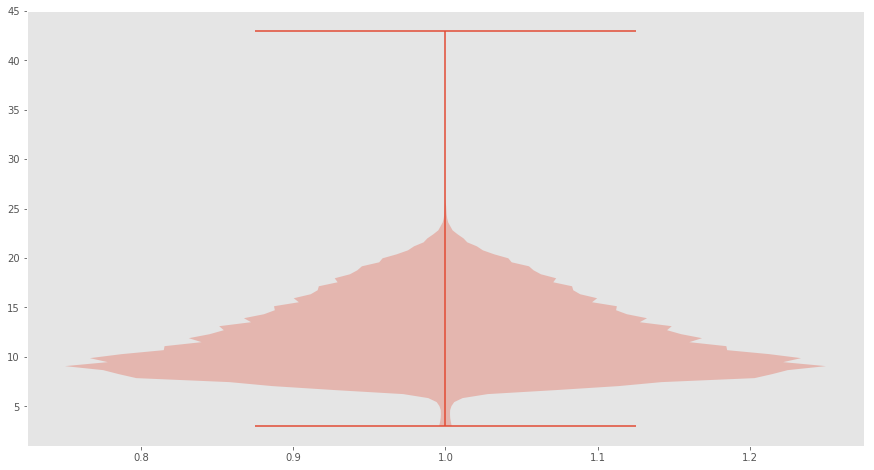

In [11]:
print("Violet plot before padding")
plt.figure(figsize = (15,8))
plt.violinplot([len(list_) for list_ in new_data_index])
plt.show()

In [12]:
maxlen = 23
new_data_index = data_replace_from_dict(newData,word_to_index,sentence_len=maxlen-2)

#words after replacing with indices and then replacing back with 
print(newData[:10])
print(new_data_index[:10])
print(data_replace_from_dict(new_data_index,index_to_word,sentence_len=maxlen-2,top_k= 10,replaced_type_= 'int'))


[['you', 'must', 'be', 'very', 'fast', '.', 'hunting', 'is', 'one', 'of', 'my', 'favorite', 'hobbies', '.'], ['that', 'is', 'awesome', '.', 'do', 'you', 'have', 'a', 'favorite', 'season', 'or', 'time', 'of', 'year', '?'], ['what', 'is', 'your', 'favorite', 'meat', 'to', 'eat', '?'], ['hi', ',', 'how', 'are', 'you', 'doing', 'today', '?'], ['i', 'am', 'spending', 'time', 'with', 'my', '4', 'sisters', 'what', 'are', 'you', 'up', 'to'], ['wow', ',', 'four', 'sisters', '.', 'just', 'watching', 'game', 'of', 'thrones', '.'], ['i', 'agree', '.', 'what', 'do', 'you', 'do', 'for', 'a', 'living', '?'], ['that', 'is', 'cool', 'my', 'mom', 'does', 'the', 'same', 'thing'], ['tell', 'me', 'more', 'about', 'yourself'], ['i', 'enjoy', 'hanging', 'with', 'my', 'mother', 'she', 'is', 'my', 'best', 'friend']]
[[1008, 3, 200, 38, 72, 385, 2, 663, 9, 73, 23, 10, 51, 144, 2, 1009], [1008, 14, 9, 109, 2, 8, 3, 15, 6, 51, 610, 103, 56, 23, 208, 4, 1009], [1008, 22, 9, 34, 51, 295, 7, 100, 4, 1009], [1008, 46

Violet plot after padding
Violet plot before padding


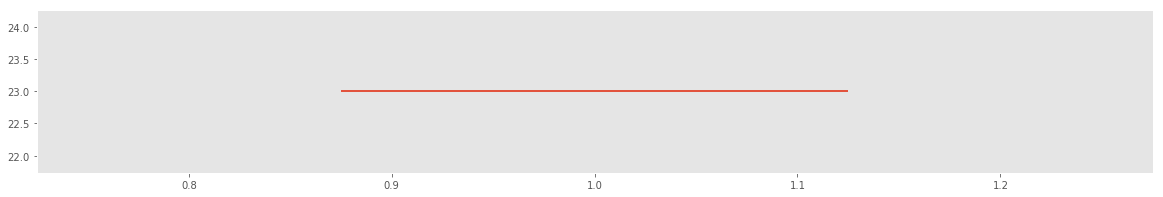

In [13]:
new_data_index_padded = pad_sequences(new_data_index,padding='post')
print("Violet plot after padding")
print("Violet plot before padding")
plt.violinplot([len(list_) for list_ in new_data_index_padded])
plt.show()

### Saving

Now is a good time to save your data (end of processing). An example code using the pickle library is shown below.


In [14]:
import pickle

#save
with open("data.pkl", "wb") as file:
    pickle.dump([new_data_index_padded, word_to_index, index_to_word], file)
    
#load
with open("data.pkl", "rb") as file:
    [new_data_index_padded, word_to_index, index_to_word] = pickle.load(file)

## Building and training generative models of language

### RNN vs LSTM vs GRU 

Build, train and compare generative models of language based on RNNs with different recurrent units (SimpleRNN, GRU and LSTM). 

The target of the network will be to approximate the word transition probabilities Pr(word[n+1]|H[n]) with H[n]=f(word[:n]) being the hidden state of the network.  

**code** You should complete the proposed model (using the Keras API rather than the Sequential model for more flexibility). Be sure to understand each line. The embedding layer allows to transform an integer to a dense vector. That would be our input to the recurrent network - each sentence is mapped to a sequence of vectors, each representing a single word. You can then design your own readout(s) and output layers. By default, use the proposed meta parameters. You can adapt them if you have more or less computing power (32 epochs should take around 30 minutes). [2 pts]

**Question** How will your networks deal with the artificial word 'PADD' that you added at the end of each sentences  [2 pts]

**Answer** 'PADD' will be removed when going through the embedding layer, as the option mask_zero has been set to True.

**code** Then train three different networks with the same architecture but using different recurrent units (simpleRNN, GRU and LSTM). Save the learning history (training/validation loss and accuracy for each epoch) as well as the models. [1 pt]

**Question** How can you use this network to approximate the word transition probabilities? What will be the inputs and targets of the network at each batch? Give the input/output tensor dimensions. [2 pts]

**Answer**  The output matrix indicates the probability of each word transferred from the corresponding forward word(s). At each batch, the input is the indexed sentence except the last word, and the output is the probability matrix of the sentence except 'START'. The input tensor dimension is (22,1) and the output tensor dimension is (22,1646). 

**Figure** Show the learning curves (training and validation loss) for the different recurrent units. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the different recurrent units. [1 pt]

**Question:** Which recurrent unit yields the best validation accuracy? Which is the fastest learner? [1 pt]

**Answer**:  LSTM and GRU yield the similar best validation accuracy around 44%. GRU is the fastest learner based on the time spent for each epoch.


**Question:** Do you observe an overfitting effect? Where and for which case? Give a possible explanation. [1 pt] 

**Answer**:  There is an overfitting effect after 10 epoches in LSTM recurrent unit. LSTM is the fastest learner as indidated in last question, so the overfitting effect of it appears first within the same number of epoches compared to simpleRNN and GRU.

**Question:** Suggest one option modifying your dataset to decrease overfitting. [1 pt]

**Answer**: Remove more sentences containing low frequency words.

**Question:** Suggest one possible option modifying your network to decrease overfitting. [1 pt]

**Answer**:  Implement the regularization in each neural, and add dropout layers.


**Question:** Suggest one possible option modifying the training modalities to counter overfitting. [1 pt]   

**Answer**: use of earlystopping.

In [15]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 50
validation_split = 0.2
maxlen = 23
dataset_cut = -1
readout_size = 256
num_words =max(index_to_word)+1

In [16]:
from keras.utils import to_categorical
I = {}
E = {}
H = {}
R = {}
Y = {}
models = {}
logs = {}
#filtered_sentences, dictionary, tokens
X = np.array(new_data_index_padded)
T = np.array([to_categorical(sen, num_classes=num_words) for sen in X])

# RNN , LSTM , GRU 

In [18]:
#Model suggestion
for model_type in ['RNN','LSTM','GRU']:
    print("***********")
    print([model_type]*10)
    I[model_type] = Input(shape=(maxlen-1,), name="input")
    E[model_type] = Embedding(num_words, embedding_size, mask_zero=True, name="embedding")(I[model_type])

    #your network here
    recurring_layer = None
    if(model_type == 'RNN'):
        recurring_layer = keras.layers.SimpleRNN(hidden_size, activation='relu', return_sequences=True)(E['RNN'])
    elif model_type == 'LSTM':
        recurring_layer = keras.layers.LSTM(hidden_size, activation='relu', return_sequences=True)(E['LSTM'])
    else:
        recurring_layer = keras.layers.GRU(hidden_size, activation='relu', return_sequences=True)(E['GRU'])
    H[model_type] = recurring_layer
    R[model_type] = TimeDistributed(keras.layers.Dense(readout_size, activation='relu'))(H[model_type])
    Y[model_type] = TimeDistributed(keras.layers.Dense(num_words, activation='softmax'),name='output')(R[model_type])

    models[model_type] = Model(inputs = [I[model_type]], outputs = [Y[model_type]])
    models[model_type].compile(
        loss='categorical_crossentropy', 
        optimizer=Adam(),
        metrics=['acc'])
    models[model_type].summary()

    print(X[:,:-1].shape, T[:,1:].shape)
    logs[model_type] = models[model_type].fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                        epochs=epochs,  verbose=2,
                                        validation_split=validation_split, 
                                        batch_size=batch_size).history

    #save
    with open(model_type+"model_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "wb") as file:
        pickle.dump(logs[model_type], file)
    models[model_type].save(model_type+"model_"+str(embedding_size)+'_'+str(hidden_size))

***********
['RNN', 'RNN', 'RNN', 'RNN', 'RNN', 'RNN', 'RNN', 'RNN', 'RNN', 'RNN']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           129280    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 22, 64)            12352     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 22, 256)           16640     
_________________________________________________________________
output (TimeDistributed)     (None, 22, 1010)          259570    
Total params: 417,842
Trainable params: 417,842
Non-trainable params: 0
_________________________________________________________________
(50793, 22) (50793, 22, 1010)
Train on 40633 samples,

Epoch 21/50
 - 41s - loss: 2.3251 - acc: 0.4621 - val_loss: 2.6311 - val_acc: 0.4423
Epoch 22/50
 - 43s - loss: 2.3122 - acc: 0.4637 - val_loss: 2.6319 - val_acc: 0.4431
Epoch 23/50
 - 44s - loss: 2.3002 - acc: 0.4650 - val_loss: 2.6357 - val_acc: 0.4427
Epoch 24/50
 - 41s - loss: 2.2887 - acc: 0.4662 - val_loss: 2.6435 - val_acc: 0.4434
Epoch 25/50
 - 42s - loss: 2.2785 - acc: 0.4677 - val_loss: 2.6459 - val_acc: 0.4434
Epoch 26/50
 - 42s - loss: 2.2681 - acc: 0.4686 - val_loss: 2.6585 - val_acc: 0.4430
Epoch 27/50
 - 41s - loss: 2.2594 - acc: 0.4699 - val_loss: 2.6508 - val_acc: 0.4439
Epoch 28/50
 - 42s - loss: 2.2485 - acc: 0.4710 - val_loss: 2.6625 - val_acc: 0.4431
Epoch 29/50
 - 42s - loss: 2.2381 - acc: 0.4724 - val_loss: 2.6766 - val_acc: 0.4426
Epoch 30/50
 - 43s - loss: 2.2287 - acc: 0.4735 - val_loss: 2.6812 - val_acc: 0.4433
Epoch 31/50
 - 45s - loss: 2.2190 - acc: 0.4748 - val_loss: 2.6775 - val_acc: 0.4432
Epoch 32/50
 - 45s - loss: 2.2113 - acc: 0.4753 - val_loss: 2.695

In [17]:
#load
with open("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    RNNmodel_log = pickle.load(file)
RNNmodel = load_model("RNNmodel_"+str(embedding_size)+'_'+str(hidden_size))
#load
with open("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    LSTMmodel_log = pickle.load(file)
LSTMmodel = load_model("LSTMmodel_"+str(embedding_size)+'_'+str(hidden_size))

#load
with open("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size)+"_log.pkl", "rb") as file:
    GRUmodel_log = pickle.load(file)
GRUmodel = load_model("GRUmodel_"+str(embedding_size)+'_'+str(hidden_size))

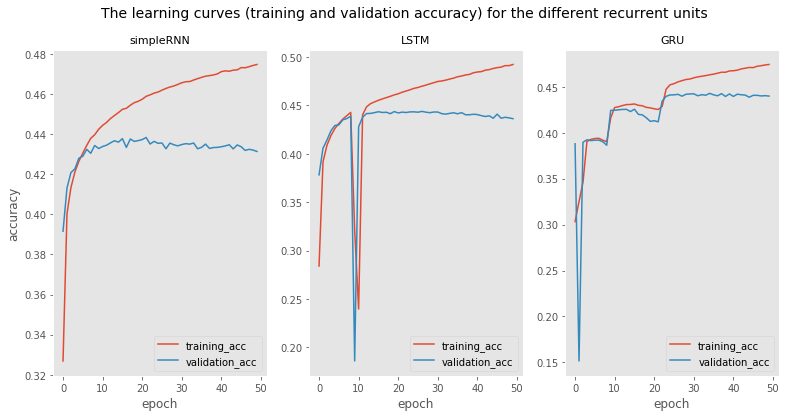

In [18]:
fig, ax = plt.subplots(1,3,figsize=(13,6))
fig.suptitle('The learning curves (training and validation accuracy) for the different recurrent units',size=14)

ax[0].set_title('simpleRNN',size=11)
ax[0].plot(RNNmodel_log['acc'], label = "training_acc")
ax[0].plot(RNNmodel_log['val_acc'], label = "validation_acc")
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend()


ax[1].set_title('LSTM',size=11)
ax[1].plot(LSTMmodel_log['acc'], label = "training_acc")
ax[1].plot(LSTMmodel_log['val_acc'], label = "validation_acc")
ax[1].set_xlabel('epoch')
ax[1].legend()

ax[2].set_title('GRU',size=11)
ax[2].plot(GRUmodel_log['acc'], label = "training_acc")
ax[2].plot(GRUmodel_log['val_acc'], label = "validation_acc")
ax[2].set_xlabel('epoch')
ax[2].legend()
plt.show();

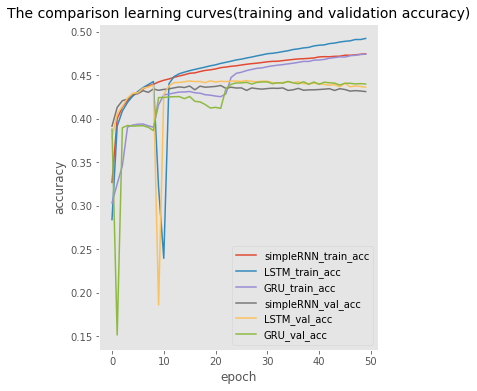

In [19]:
plt.figure(figsize=(5,6))
plt.title('The comparison learning curves(training and validation accuracy)',size=14)

plt.plot(RNNmodel_log['acc'], label = "simpleRNN_train_acc")
plt.plot(LSTMmodel_log['acc'], label = "LSTM_train_acc")
plt.plot(GRUmodel_log['acc'], label = "GRU_train_acc")
plt.plot(RNNmodel_log['val_acc'], label = "simpleRNN_val_acc")
plt.plot(LSTMmodel_log['val_acc'], label = "LSTM_val_acc")
plt.plot(GRUmodel_log['val_acc'], label = "GRU_val_acc")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show();

### Optimal network size

Compare the learning curves for three networks with 64 (previous exercise), 128 and 256 GRUs (single layer) and one with two hidden layers of 64 GRUs. 

**Code** Build and train the networks. Apply EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2). Use transfer learning, do not train from scratch your embedding layer, rather re-use the embedding layer from your best performing network in the last exercise. [4 pts]

**Figure** Show the learning curves (training and validation loss) for the four models. [1 pt]

**Figure** Show the learning curves (training and validation accuracy) for the four models. [1 pt]

**Question** List and briefly explain the differences in the learning curves for the different models? [2 pts]

**Answer** The different models are early stopped at different epoches with around similar accuracy, because the convergence rate is different for the different models.

**Question** What effect had EarlyStopping? Give one advantage and one drawback. [2 pts]

**Answer** EarlyStopping stopped the training process when overfitting happens, ie validation loss started to increase. The advantage is getting rid of the overfitting and the draw back is the insufficient training (probably stuck at local minimum).

**Question** What is your best model? Why? [1 pt]

**Answer** Best model is 128 cell GRU because it trains as fast as 256 cell gru and also like 64 X 2 layer GRU but it's the simplest architecture, so fewer parameters to train. 



In [23]:
def genModel(num_gru_cells,num_gru_layers):
    layers = []
    print("Number of GRU cells is {} and number of GRU layers is {}".format(num_gru_cells,num_gru_layers))
    layers.append(Input(shape=(maxlen-1,), name="input"))
    layers.append(Embedding(num_words, embedding_size, weights=best_model.layers[1].get_weights(),mask_zero=True, name="embedding")(layers[0]))

    #your network here
    recurring_layer = None
    
    for i in range(num_gru_layers):
        if( num_gru_layers>1 and i<num_gru_layers-1):
            layers.append(keras.layers.GRU(num_gru_cells, activation='relu', return_sequences=True)(layers[-1]))
        else:
            layers.append(keras.layers.GRU(num_gru_cells, activation='relu', return_sequences=True)(layers[-1]))
    layers.append(TimeDistributed(keras.layers.Dense(hidden_size, activation='relu'))(layers[-1]))
    layers.append(TimeDistributed(keras.layers.Dense(num_words, activation='softmax'),name='output')(layers[-1]))
    model = Model(inputs = [layers[0]], outputs = [layers[-1]])
    model.compile(
        loss='categorical_crossentropy', 
        optimizer=Adam(),
        metrics=['acc'])
    model.summary()
    es = keras.callbacks.EarlyStopping (monitor='val_acc', min_delta=0.001, patience=2)
    log = model.fit({'input': X[:dataset_cut,:-1]}, {'output': T[:dataset_cut,1:]}, 
                                        epochs=epochs,  verbose=2,
                                        validation_split=validation_split, 
                                        batch_size=batch_size,callbacks=[es]).history
    return log,model




best_model = models['GRU']
log_128,model_128 = genModel(128,1)




Number of GRU cells is 128 and number of GRU layers is 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           129280    
_________________________________________________________________
gru_2 (GRU)                  (None, 22, 128)           98688     
_________________________________________________________________
time_distributed_4 (TimeDist (None, 22, 64)            8256      
_________________________________________________________________
output (TimeDistributed)     (None, 22, 1010)          65650     
Total params: 301,874
Trainable params: 301,874
Non-trainable params: 0
_________________________________________________________________
Train on 40633 samples, validate on 10159 samples
Epoch 1/50
 - 38s - loss: 3.4

In [24]:
log_256,model_256 = genModel(256,1)


Number of GRU cells is 256 and number of GRU layers is 1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           129280    
_________________________________________________________________
gru_3 (GRU)                  (None, 22, 256)           295680    
_________________________________________________________________
time_distributed_5 (TimeDist (None, 22, 64)            16448     
_________________________________________________________________
output (TimeDistributed)     (None, 22, 1010)          65650     
Total params: 507,058
Trainable params: 507,058
Non-trainable params: 0
_________________________________________________________________
Train on 40633 samples, validate on 10159 samples
Epoch 1/50
 - 35s - loss: 3.4

In [25]:
log_64_2,model_64_2 = genModel(64,2)

Number of GRU cells is 64 and number of GRU layers is 2
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 22)                0         
_________________________________________________________________
embedding (Embedding)        (None, 22, 128)           129280    
_________________________________________________________________
gru_4 (GRU)                  (None, 22, 64)            37056     
_________________________________________________________________
gru_5 (GRU)                  (None, 22, 64)            24768     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 22, 64)            4160      
_________________________________________________________________
output (TimeDistributed)     (None, 22, 1010)          65650     
Total params: 260,914
Trainable params: 260,914
Non-trainable params: 0
______________

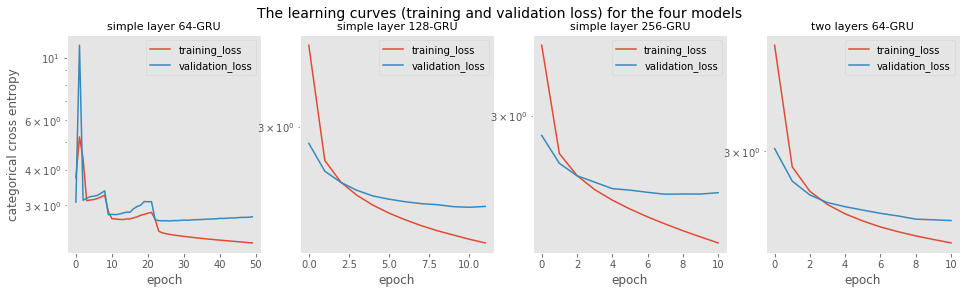

In [26]:
fig, ax = plt.subplots(1,4,figsize=(16,4))
fig.suptitle('The learning curves (training and validation loss) for the four models',size=14)

ax[0].set_title('simple layer 64-GRU',size=11)
ax[0].plot(GRUmodel_log['loss'], label = "training_loss")
ax[0].plot(GRUmodel_log['val_loss'], label = "validation_loss")
ax[0].set_ylabel('categorical cross entropy')
ax[0].set_xlabel('epoch')
ax[0].set_yscale('log')
ax[0].legend()


ax[1].set_title('simple layer 128-GRU',size=11)
ax[1].plot(log_128['loss'], label = "training_loss")
ax[1].plot(log_128['val_loss'], label = "validation_loss")
ax[1].set_xlabel('epoch')
ax[1].set_yscale('log')
ax[1].legend()

ax[2].set_title('simple layer 256-GRU',size=11)
ax[2].plot(log_256['loss'], label = "training_loss")
ax[2].plot(log_256['val_loss'], label = "validation_loss")
ax[2].set_xlabel('epoch')
ax[2].set_yscale('log')
ax[2].legend()

ax[3].set_title('two layers 64-GRU',size=11)
ax[3].plot(log_64_2['loss'], label = "training_loss")
ax[3].plot(log_64_2['val_loss'], label = "validation_loss")
ax[3].set_xlabel('epoch')
ax[3].set_yscale('log')
ax[3].legend()


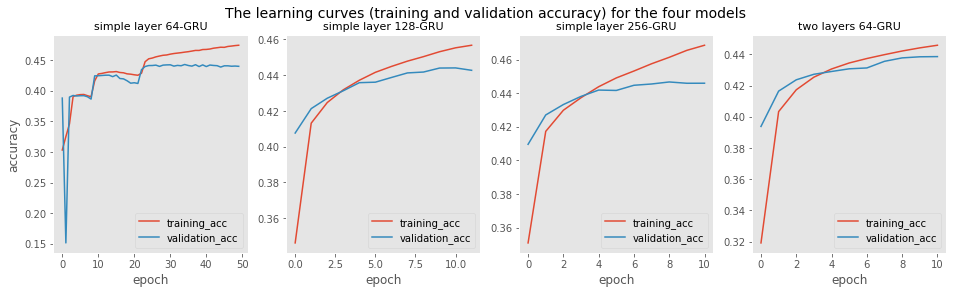

In [27]:
fig, ax = plt.subplots(1,4,figsize=(16,4))
fig.suptitle('The learning curves (training and validation accuracy) for the four models',size=14)

ax[0].set_title('simple layer 64-GRU',size=11)
ax[0].plot(GRUmodel_log['acc'], label = "training_acc")
ax[0].plot(GRUmodel_log['val_acc'], label = "validation_acc")
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend()


ax[1].set_title('simple layer 128-GRU',size=11)
ax[1].plot(log_128['acc'], label = "training_acc")
ax[1].plot(log_128['val_acc'], label = "validation_acc")
ax[1].set_xlabel('epoch')
ax[1].legend()

ax[2].set_title('simple layer 256-GRU',size=11)
ax[2].plot(log_256['acc'], label = "training_acc")
ax[2].plot(log_256['val_acc'], label = "validation_acc")
ax[2].set_xlabel('epoch')
ax[2].legend()

ax[3].set_title('two layers 64-GRU',size=11)
ax[3].plot(log_64_2['acc'], label = "training_acc")
ax[3].plot(log_64_2['val_acc'], label = "validation_acc")
ax[3].set_xlabel('epoch')
ax[3].legend()
plt.show();

### Generate sentences

Now you will generate new sentences from your best performing model.

**Code** To achieve that, use the provided sample function below to generate new sentences from your model. You should start by constructing a sentence that starts with the 'START' artificial word and all other words being the 'PADD' artificial word. Then sample the first word from the corresponding probabilities given by your model. Add this word to the sentence and continue like this until you sample the 'END' artificial word or the maximum sentence length. [2 pts]

**Code** Generate 10 sentences for different sampling temperature in [0., 0.25, 0.5, 0.75, 1., 1.5., 2.]. [1 pt]

**7 Figures** For each temperature, use matplotlib imshow to plot the probablities of every word in one generated sentence (and only these words) at each time step. y-axis should be the words that are present in the sentence. x-axis the timesteps and the imshow value the probabilities given by the model for all words in the sentence at each timestep. Use the a colormap where 0 is white, e.g. cmap='Greys'. [2 pts]

**Code** Finally, seed your model with two different beginnings of max 4 words and let it generate 10 possible continuations (use sampling temperature of 1.). [2 pts]

**Question** What is the effect of sampling temperature on the generated sentences? [1 pt]

**Answer**Sampling temperature controls the randomness of sampling process. With temperature, the logits will be mapped into softmax function. A higher temperature will flatten the probality, letting the words with lower logits be more likely to be selected.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 0 corresponds to? [1 pt] 

**Answer**The word with the maximum probability is sampled, which is also called 'Greedy sampling'.

**Question** In terms of sampling a probability distribution, what does a sampling temperature of 1. corresponds to? [1 pt] 

**Answer**The word is sampled according to the weight of softmax probability, which is also called 'Random sampling'.

**Question** In terms of sampling a probability distribution, what does a very high sampling temperature corresponds to? [1 pt]

**Answer** Higher sampling temperature corresponds to the more random sampling process.

**Question** Based on the plotted word probabilities, explain how a sentence is generated. [2 pts]

**Answer** Each word is sampled according to the softmax probability vector generated from the model with the effect of sampling temperature. Started with the empty sentences started with '#START', we feed it into our network to get the probability matrix. We sample the first word with temperature based on the first row of the matrix. Repeatedly operate it until '#END' or reaching the max length.

**Question** Do you observe timesteps with more than one word with non-zero probability? How do these probable words relate in terms of language? [1 pt]

**Answer**  Yes, these probable words relate the synonyms in terms of language or similarly meaning words in context.

In [20]:
def sample(preds, temperature=1.):
    # helper function to sample an index from a probability array
    if temperature == 0.:
        return np.argmax(preds)
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)


In [54]:
def predictGenRandSent(model, temperature):
    # initialize
    sent_init = [word_to_index['#START']] + [word_to_index['#PADD'] for _ in range(21)]
    sent_init = np.array(sent_init)
    sent_init = sent_init.reshape((1,-1))
    sent_ret = []
    prob_record = np.zeros((num_words,maxlen-1))
    for i in range(maxlen-1):
        probs = model.predict_on_batch(sent_init)
        prob_record[:,i] = probs[0,i,:]
        step = sample(probs[0,i,:], temperature)
        if index_to_word[step] == '#END':
            break
        sent_ret.append(index_to_word[step])
        if i == maxlen-2:
            break
        sent_init[0,i+1] = step
    return ' '.join(sent_ret), prob_record



In [55]:
temps =  [0., 0.25, 0.5, 0.75, 1., 1.5, 2.]
best_model = LSTMmodel
sents_list = []
for temperature in temps:
    current_list = []
    for j in range(10):
        sent_generate, prob_matrix = predictGenRandSent(best_model, temperature)
        current_list.append(sent_generate)
    sents_list.append(current_list)

C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [26]:
for (tp, sents) in zip(temps, sents_list):
    print('+++++++++++++++++++ Temperature: %.2f +++++++++++++++++++++' % tp)
    for sent in sents:
        print(sent)

+++++++++++++++++++ Temperature: 0.00 +++++++++++++++++++++
i am doing well . how about you ?
i am doing well . how about you ?
i am doing well . how about you ?
i am doing well . how about you ?
i am doing well . how about you ?
i am doing well . how about you ?
i am doing well . how about you ?
i am doing well . how about you ?
i am doing well . how about you ?
i am doing well . how about you ?
+++++++++++++++++++ Temperature: 0.25 +++++++++++++++++++++
i am doing well , just got back from a bike ride . how are you ?
i am doing well . how about you ?
i am doing well , how about you ?
i am doing well , just got back from a bike ride . how are you ?
i am doing well . how about you ?
i am doing well . how about you ?
i am doing well . how about you ?
i am good and you
i am good and you
i am good . how about you ?
+++++++++++++++++++ Temperature: 0.50 +++++++++++++++++++++
i am good and you
i do not have any kids
i am doing well . how about you ?
i am good . how are you ?
do you have any

C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


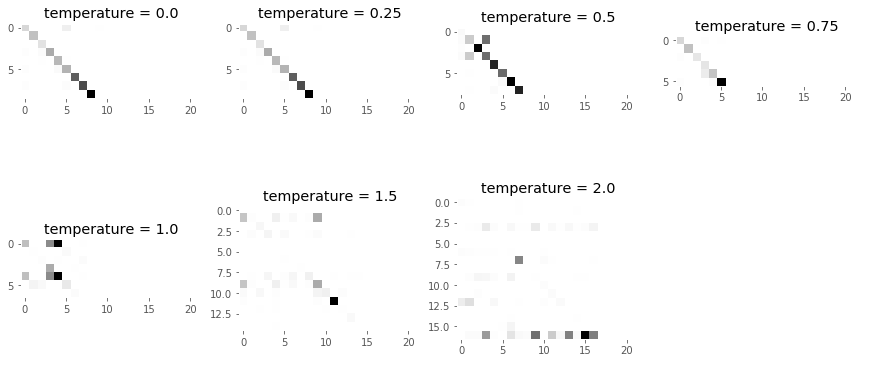

In [27]:
def plotProbSen(sent, prob_matrix):
    sent_token = sent.split(' ')
    sent_token_ind = [word_to_index[tok] for tok in sent_token]
    prob_matrix = prob_matrix[[sent_token_ind]]
    return prob_matrix
import math
fig,ax = plt.subplots(2,4,figsize=(15,7))
for (i,temperature) in enumerate(temps):
    sent_generate, prob_matrix = predictGenRandSent(best_model, temperature)
    probs = plotProbSen(sent_generate, prob_matrix)
    ax[math.floor(i/4)][i-math.floor(i/4)*4].imshow(probs, cmap='Greys')
    ax[math.floor(i/4)][i-math.floor(i/4)*4].set_title('temperature = {}'.format(temperature))
    
ax[1][3].axis('off')
plt.show()

###  Word embedding visualization

Here, you are asked to visualize the embedding layer. 

**Code** To do that, project in 2D the embedding vectors for different words. Use t-SNE, a projection that conserve the neighborhood relationships between vectors. HINT: Build a Keras model that takes as input a list of words and outputs a list of vector embeddings as learned by your best performing model. Use t-SNE dimensionality reduction (from sklearn.manifold import TSNE). [2 pts]

**Figure** Plot the projection of the first 200 most frequent words in a 2D plot. On the plot, write the words. [2 pt] 

**Question** Do you observe clusters of words with similar meaning or role in language? Report three of them here. [1 pt]

**Answer** yes . like hey, hello in 1 cluster :  what, what, where in another cluseter,  and love , enjoy make another cluster. 

**Question** Why is having similar vector representation for similar words a good approach for such models? Explain using the example clusters from before and argue in terms of prediction accuracy and/or generalization. [2 pts]

**Answer** Word vector in onehot encoding are around 1000 + dimensional like in my case, finding similar words in such high dimension is hard, due to curse of dimensionality and we can't have enough samples to cluster well in such a case. So embeddings help find a lower dim representation of words which help us 

In [28]:
embedded_matrix = best_model.get_layer('embedding').get_weights()
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2).fit_transform(embedded_matrix[0])


In [29]:
words = [w for sen in newData for w in sen]
wfreq = Counter(words)
wfreq_top200 = sorted(wfreq.items(), key=lambda x: x[1], reverse=True)[:200]
words_top200 = [w[0] for w in wfreq_top200]
words_top200_ind = [word_to_index[w] for w in words_top200]
vectors_top200 = X_embedded[words_top200_ind]

In [30]:
np.shape(vectors_top200)

(200, 2)

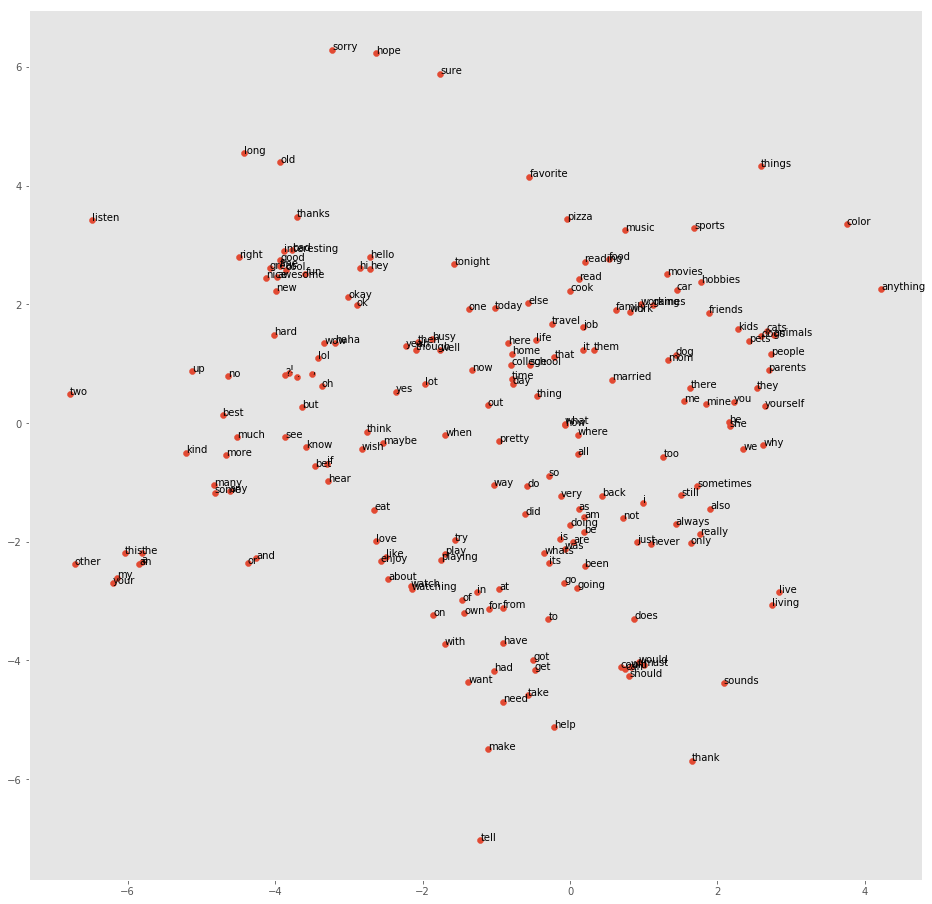

In [31]:
fig, ax = plt.subplots(figsize=(16,16))
ax.scatter(vectors_top200[:,0], vectors_top200[:, 1])

for i in range(200):
    ax.annotate(words_top200[i], (vectors_top200[i,0], vectors_top200[i,1]))

## Chatbot

Finally, you will construct a model with which you can chat. The network will take as input a sentence and output a response.

**Code** For that, you should go back to your original data and construct a new dataset containing pairs of sentences, where each pair is a sentence and its answer. Be careful to not include any pair of sentences that contains words not present in your filtered dictionary. [2 pts]

**Code** You should then tokenize, padd, truncate each sentence. Only the answers need the 'START' and 'END' artificial words. [1 pt]

We provide you with a possible model, you are welcome to change it. This model uses an LSTM layer to encode the first sentence (the context). The final state of this LSTM layer is transfered to initialize the state of a decoder LSTM layer from which the answer sentence will be generated. 

**Code** Train your chatbot model on your dataset. [1 pt]

**Code** Adapt your sentence generation code from before so that you can generate an answer given a context sentence from your model. [2 pts] 

**Code** After training, randomly select 10 context-answers pairs from your data and show both the real answer (the one from the data) and the generated one for two different sampling temperatures (e.g. 0.5 and 1.0). [2 pts]

**Question** How similar are the generated answers and the real ones? Does your model provide probable answers (given the dataset)? Report here one good and one bad example. [2 pts]

**Answer**  
Good example :  
                Question: so do you like your work ?  
                Real Answer: it is the only thing i like in my life . what do you do ?  
                Predicted Answer: yes i do . i like music  
Bad example :   
                Question: it sounds like the really care about you .  
                Real Answer:yes , i have amazing friends .  
                Predicted Answer:yes i am to have children interested older  

**Question** Which sampling temperature gives better answers? why? [2 pts]

**Answer**  Sampling temperature equals to 0.5 gives better answer, because the generated answers are more similar to the real answers.

**Question** Would it be good if your model was able to reproduce exactly each real answer? Why? [1 pt]

**Answer** No, the reproduced answers maybe overfit to the real answers.

**Code** Entertain yourself with your model. Write some code to chat with your bot, let it discuss with itself, ... be creative! [2 **bonus** pts]




In [32]:
training_chat = getRawDataFromFile( datapath="data2/personachat/",file="train_both_revised.txt")


In [33]:
#training_chat = [subitem for item in training_chat for subitem in item]

In [34]:
def generateSentPairs(trainingData):
    # transfer diags to pairs
    diag_pair = [[conv[i], conv[i+1]] for conv in trainingData for i in range(len(conv)-1)]
    
    def cleanDiag(diags):
        diag_w = list(set([w for diag in diags for w in diag.split(' ')]))
        for w in diag_w:
            if w not in word_to_index.keys():
                return False
        return True
    
    diag_pair_filtered = list(filter(cleanDiag, diag_pair))
    return diag_pair, diag_pair_filtered    

In [35]:
diag_pair, diag_pair_filter = generateSentPairs(training_chat)
print('The number of dialogs before filter is {}'.format(len(diag_pair)))
print('The number of dialogs after filter is {}'.format(len(diag_pair_filter)))

The number of dialogs before filter is 122486
The number of dialogs after filter is 19749


In [36]:
# start, end, padding
diag_pair_start_end = [[conv[0].split(' '), ['#START'] + conv[1].split(' ') + ['#END']] for conv in diag_pair_filter]
diag_pair_start_end[0]

[['hi', ',', 'how', 'are', 'you', 'doing', 'today', '?'],
 ['#START',
  'i',
  'am',
  'spending',
  'time',
  'with',
  'my',
  '4',
  'sisters',
  'what',
  'are',
  'you',
  'up',
  'to',
  '#END']]

In [37]:
# transfer the sent token to integer
diag_pairint_no_pad = [[[word_to_index[w] for w in sent] for sent in conv] for conv in diag_pair_start_end]
diag_pairint_no_pad[0]


[[46, 5, 25, 16, 3, 48, 63, 4],
 [1008, 1, 11, 820, 56, 32, 10, 409, 582, 22, 16, 3, 75, 7, 1009]]

In [38]:
# add padding
maxlen=23
diag_pair_padding = [keras.preprocessing.sequence.pad_sequences(sequences=conv,
                                                               maxlen=maxlen,
                                                               dtype=np.int,
                                                               padding='post',
                                                               truncating='post',
                                                               value=0) for conv in diag_pairint_no_pad]
diag_pair_padding[0]

array([[  46,    5,   25,   16,    3,   48,   63,    4,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [1008,    1,   11,  820,   56,   32,   10,  409,  582,   22,   16,
           3,   75,    7, 1009,    0,    0,    0,    0,    0,    0,    0,
           0]])

In [39]:
# questions and answers
from keras.utils import to_categorical
Q = [conv[0][:-2] for conv in diag_pair_padding]
AnsInput = np.array([conv[1][:-1] for conv in diag_pair_padding])
AnsOutput = [conv[1][1:] for conv in diag_pair_padding]
AVectorOutput = np.array([[to_categorical(w, num_classes=num_words) for w in sent] for sent in AnsOutput])
Ques = np.array(Q)


In [40]:
print(Ques.shape, AnsInput.shape, AVectorOutput.shape)

(19749, 21) (19749, 22) (19749, 22, 1010)


In [41]:
#Meta-parameters
embedding_size = 128
hidden_size = 64
dropout = 0.
recurrent_dropout = 0.

batch_size = 64
epochs = 50
validation_split = 0.2

dataset_cut = -1
readout_size = 256

In [42]:
context = Input(shape=(maxlen-2,), name="input_data")
shared_embedding = LSTMmodel.get_layer('embedding')
context_embedding = shared_embedding(context)

encoder_y, encoder_h, encoder_c = LSTM(hidden_size, 
            return_sequences=False,
            return_state=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            go_backwards=True,
            name="encoder")(context_embedding)

answer = Input(shape=(maxlen-1,), name="input_answer")
answer_embedding = shared_embedding(answer)

decoder_input = answer_embedding
decoder = LSTM(hidden_size, 
            return_sequences=True,
            stateful=False,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            name="decoder")(answer_embedding, initial_state=[encoder_h, encoder_c])

R = TimeDistributed(Dense(embedding_size, activation='relu'), name='readout')(decoder)
Y = TimeDistributed(Dense(num_words, activation='softmax'), name='output')(R)

Chatbot = Model(inputs = [context, answer], outputs = [Y])
Chatbot.compile(
    loss='categorical_crossentropy', 
    optimizer=Adam(),
    metrics=['acc'])
Chatbot.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_answer (InputLayer)       (None, 22)           0                                            
__________________________________________________________________________________________________
input_data (InputLayer)         (None, 21)           0                                            
__________________________________________________________________________________________________
embedding (Embedding)           multiple             129280      input_data[0][0]                 
                                                                 input_answer[0][0]               
__________________________________________________________________________________________________
encoder (LSTM)                  [(None, 64), (None,  49408       embedding[1][0]                  
__________

In [52]:
ChatBotLog = Chatbot.fit([Ques, AnsInput],[AVectorOutput],
                         epochs=epochs, 
                         validation_split=validation_split, 
                         batch_size=batch_size).history

Train on 15799 samples, validate on 3950 samples
Epoch 1/50
15799/15799 [==============================] - 30s 2ms/step - loss: 4.2458 - acc: 0.2551 - val_loss: 3.4573 - val_acc: 0.3518
Epoch 2/50
15799/15799 [==============================] - 26s 2ms/step - loss: 3.2653 - acc: 0.3686 - val_loss: 3.1161 - val_acc: 0.3896
Epoch 3/50
15799/15799 [==============================] - 27s 2ms/step - loss: 3.0321 - acc: 0.3909 - val_loss: 2.9747 - val_acc: 0.3994
Epoch 4/50
15799/15799 [==============================] - 29s 2ms/step - loss: 2.9072 - acc: 0.4030 - val_loss: 2.8924 - val_acc: 0.4094
Epoch 5/50
15799/15799 [==============================] - 27s 2ms/step - loss: 2.8196 - acc: 0.4118 - val_loss: 2.8353 - val_acc: 0.4154
Epoch 6/50
15799/15799 [==============================] - 27s 2ms/step - loss: 2.7531 - acc: 0.4188 - val_loss: 2.7992 - val_acc: 0.4162
Epoch 7/50
15799/15799 [==============================] - 26s 2ms/step - loss: 2.7003 - acc: 0.4245 - val_loss: 2.7710 - val_acc:

In [53]:
#save
with open("Chatbot"+"_log.pkl", "wb") as file:
    pickle.dump(ChatBotLog, file)
Chatbot.save("Chatbot")

C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\keras\engine\network.py:872: UserWarning: Layer decoder was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'encoder_1/while/Exit_3:0' shape=(?, 64) dtype=float32>, <tf.Tensor 'encoder_1/while/Exit_4:0' shape=(?, 64) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


In [43]:
Chatbot = load_model('Chatbot')

# Test response to question

In [44]:
def predictAnswer(q, model, temp):
    # low performce run encode repeatedly
    ans = np.array([[word_to_index['#START']] + [word_to_index['#PADD'] for _ in range(maxlen-2)]])
    q_ind = np.array([[word_to_index[w] for w in q.split(' ')]])
    # padding
    q_input = keras.preprocessing.sequence.pad_sequences(sequences=q_ind,
                                                               maxlen=maxlen,
                                                               dtype=np.int,
                                                               padding='post',
                                                               truncating='post',
                                                               value=0)[:, :-2]
#     print(q_input.shape)
    ans_ret = []
    
    for i in range(maxlen-1):
        preds = model.predict([q_input, ans])[0]
        word_ind = sample(preds=preds[i], temperature=temp)
        if index_to_word[word_ind] == '#END' or i == maxlen-2:
            break
        ans_ret.append(index_to_word[word_ind])
        ans[0, i+1] = word_ind
    return ' '.join(ans_ret)

In [45]:
select_list = np.random.randint(0,len(diag_pair_filter),10)

In [46]:
real_gene_ans_0_5 = []
real_gene_ans_1 = []
for i in select_list:
    real_gene_ans_0_5.append([diag_pair_filter[i][0], diag_pair_filter[i][1], predictAnswer(diag_pair_filter[i][0], Chatbot, 0.5)])
    real_gene_ans_1.append([diag_pair_filter[i][0], diag_pair_filter[i][1], predictAnswer(diag_pair_filter[i][0], Chatbot, 1)])

C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


In [47]:
print('Temperature = 0.5')
cnt = 1
for sents in real_gene_ans_0_5:
    print('====================== Comparison %d ===================='%cnt)
    cnt += 1
    print('Question: ' + sents[0])
    print('Real Answer: ' + sents[1])
    print('Predicted Answer: ' + sents[2])

Temperature = 0.5
====================== Comparison 1 ====================
Question: i do , sometimes . i love my alone time though
Real Answer: i understand . i like to work out alone
Predicted Answer: i am sorry to hear that .
====================== Comparison 2 ====================
Question: very cool ! i miss living in a big city like ny !
Real Answer: where did you use to live ?
Predicted Answer: sounds like that way i get to get up late running .
====================== Comparison 3 ====================
Question: wish i played guitar . instead i drink expensive wine and listen to music .
Real Answer: who is your favorite band ? mine is the story so far
Predicted Answer: what do you like to do for fun ?
====================== Comparison 4 ====================
Question: hello ! how are you today ?
Real Answer: i am great . just finished a run , i run every other day , do you keep fit ?
Predicted Answer: i am doing great ! just got home from work .
====================== Comparison 5

In [48]:
print('Temperature = 1')
cnt = 1
for sents in real_gene_ans_1:
    print('====================== Comparison %d ===================='%cnt)
    cnt += 1
    print('Question: ' + sents[0])
    print('Real Answer:' + sents[1])
    print('Predicted Answer:' + sents[2])

Temperature = 1
====================== Comparison 1 ====================
Question: i do , sometimes . i love my alone time though
Real Answer:i understand . i like to work out alone
Predicted Answer:if you can help me find my mind off of the grocery store .
====================== Comparison 2 ====================
Question: very cool ! i miss living in a big city like ny !
Real Answer:where did you use to live ?
Predicted Answer:lucky , maybe we should go surfing everyday , how cool is it
====================== Comparison 3 ====================
Question: wish i played guitar . instead i drink expensive wine and listen to music .
Real Answer:who is your favorite band ? mine is the story so far
Predicted Answer:about you ? i believe in love you i am so sorry .
====================== Comparison 4 ====================
Question: hello ! how are you today ?
Real Answer:i am great . just finished a run , i run every other day , do you keep fit ?
Predicted Answer:i am good how are you ?
=======

# Play with chatbot

In [56]:
num_conv = 20
sent1 = 'hi do you like dogs'
for i in range(num_conv):
    sent2 = predictAnswer(sent1, Chatbot, .75)
    sent1 = predictAnswer(sent2, Chatbot, .75)
    if(i==0):
        print('ChatBot1: hi do you like dogs')
    print('ChatBot2: ', sent2)
    print('ChatBot1: ', sent1)

C:\ProgramData\Anaconda3\envs\tf_env\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


ChatBot1: hi do you like dogs
ChatBot2:  i do not have any pets . do you like music
ChatBot1:  i love rap . what do you do for fun ?
ChatBot2:  i really enjoy playing sports , i take my dogs out .
ChatBot1:  nice you do not like cars either .
ChatBot2:  lucky you . i am also an art team i like to read
ChatBot1:  cool . what are you up to this morning ?
ChatBot2:  i am just getting back from my garden for christmas . how about you ?
ChatBot1:  great i dance to work at the beach , i love to draw
ChatBot2:  that sounds fun . do you have plans for work ?
ChatBot1:  yes i just read comics . i am just talking to the beach .
ChatBot2:  do you work out ? i am from my degree ? i love animals .
ChatBot1:  i have no dogs , i am in school
ChatBot2:  awesome , i bet they are also my mom . he loves to make it even .
ChatBot1:  yes . they love it ! ! ! ! ! ! !
ChatBot2:  we can not even see them
ChatBot1:  absolutely ! what do you do for a living ?
ChatBot2:  i am still in school right now i try to b